# **Stochastic Solver**

Minimising an evaluation function of the sudoku board (such as the numbers of errors), can then be optimised using some stochastic method to reduce this evaluation function to a local or global minima. The consequences of this approach is that it does not guarantee a solution to be found in a deterministically efficient time (for most stochastic `neighbour()` methods). More complex operations also mean that the time complexity of this solver can be slower than faster algorithms.

In [1634]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### **1: Grid Definition**

Since a lot of operations are performed on the different grid iterations, a `numpy` definition of the grid is required. Also a 2D implementation to help with slicing views on the array can help reduce the time and memory explosion with poor Python internals.

In [1704]:
def setup_grid(grid: str, shape: tuple[int, int]) -> np.ndarray:
    return np.asarray(list(grid), dtype=np.uint8).reshape(shape)

### **2: `P`-Matrix Definition**

A probaility matrix is used to apply a temperature `T` to assert whether a value is updated upon a stochastic iteration step. The probaility matrix cannot change static entries from the input grid so have `p=0` and when a constraint conflicts with the static constraints this should have `p=1` and an easing proability for cell value changes fluctuating between.

In [1705]:
def setup_pmat(grid: np.ndarray, shape: tuple[int, int]) -> np.ndarray:
    pmat: np.ndarray = np.ones(shape, dtype=np.float32)
    pmat[grid != 0] = 0.0
    return pmat


def setup_smat(shp: tuple[int, int]) -> np.ndarray:
    return np.random.randint(1, shp[0], shp)

### **3: Updates when Iterating**

There are many different update methods worth testing, each will be given a class definition to update both the `pmat` matrix and generating new `state` grids with associated temperture `T` values at each step.

In [1707]:
def get_row_counts(row: int, mat: np.ndarray) -> dict[int, int]:
    return dict(zip(*np.unique(mat[row, :], return_counts=True)))


def get_col_counts(col: int, mat: np.ndarray) -> dict[int, int]:
    return dict(zip(*np.unique(mat[:, col], return_counts=True)))


def get_box_counts(i: int, j: int, mat: np.ndarray) -> dict[int, int]:
    d: int = int(np.sqrt(mat.shape[0]))
    i, j = (i // d) * d, (j // d) * d
    return dict(zip(*np.unique(mat[i : i + d, j : j + d], return_counts=True)))

In [1694]:
x = range(3)

print(list(x))

[0, 1, 2]


In [1695]:
# def get_mat_counts(mat: np.ndarray, dim_size: int, box_size: int) -> dict:
#     pass


# def update_pmat(pmat: np.ndarray, smat: np.ndarray, grid: np.ndarray) -> np.ndarray:
#     # Shapes of the full grid and inner boxes
#     dim_size: int = int(np.sqrt(grid.shape[0]))
#     box_size: int = int(np.sqrt(dim_size))
#     dim_idxs = list(range(dim_size))
#     box_idxs = list(
#         (i, j)
#         for i in range(0, dim_size, box_size)
#         for j in range(0, dim_size, box_size)
#     )

#     # Indexes to search when getting counts of cell values
#     grid_row_counter: dict[int, dict] = {i: get_row_counts(i, grid) for i in dim_idxs}
#     grid_col_counter: dict[int, dict] = {i: get_col_counts(i, grid) for i in dim_idxs}
#     grid_box_counter: dict[int, dict] = {
#         i // box_size * box_size + j // box_size: get_box_counts(i, j, grid)
#         for i, j in box_idxs
#     }

#     row_ids: list[int] = list(range(dim))
#     col_ids: list[int] = list(range(dim))
#     tmp_ids: list[int] = list(range(0, dim, d))
#     box_ids: list[tuple[int, int]] = list([(i, j) for i in tmp_ids for j in tmp_ids])
#     row_s: dict = {i: get_row_counts(i, smat) for i in row_ids}
#     row_g: dict = {i: get_row_counts(i, grid) for i in row_ids}
#     col_s: dict = {j: get_col_counts(j, smat) for j in col_ids}
#     col_g: dict = {j: get_col_counts(j, grid) for j in col_ids}
#     box_s: dict = {i // d * d + j // d: get_box_counts(i, j, smat) for i, j in box_ids}
#     box_g: dict = {i // d * d + j // d: get_box_counts(i, j, grid) for i, j in box_ids}

#     pmat_new: np.ndarray = pmat.copy()

#     print(box_ctr)

#     return pmat_new

#     # for (i, j), v in np.ndenumerate(smat):
#     #     if pmat[i, j] == 0:
#     #         continue
#     #     if not check_row_hard(i, j, d, smat[i, j], grid):
#     #         pmat[i, j] = 1.0
#     #     elif not check_col_hard(i, j, d, smat[i, j], grid):
#     #         pmat[i, j] = 1.0
#     #     elif not check_box_hard(i, j, d, smat[i, j], grid):
#     #         pmat[i, j] = 1.0
#     #     else:
#     #         pmat[i, j] = 0.000001
#     #         pmat[i, j] += 0.1 if not check_row_soft(i, j, d, smat) else 0
#     #         pmat[i, j] += 0.1 if not check_col_soft(i, j, d, smat) else 0
#     #         pmat[i, j] += 0.1 if not check_box_soft(i, j, d, smat) else 0
#     # return pmat


# print(update_pmat(pmat, smat, grid)), smat

{0: {1: 2, 2: 3, 3: 1, 7: 3}, 1: {1: 2, 2: 1, 3: 1, 4: 1, 5: 1, 7: 2, 8: 1}, 2: {2: 1, 3: 3, 4: 2, 5: 2, 6: 1}, 3: {2: 1, 3: 1, 4: 1, 5: 2, 7: 3, 8: 1}, 4: {2: 2, 3: 2, 4: 1, 5: 1, 6: 1, 7: 2}, 5: {1: 1, 2: 3, 4: 2, 5: 1, 7: 1, 8: 1}, 6: {1: 1, 2: 2, 4: 1, 5: 2, 6: 1, 7: 1, 8: 1}, 7: {1: 1, 2: 2, 3: 2, 5: 1, 7: 1, 8: 2}, 8: {1: 2, 2: 1, 3: 1, 5: 1, 6: 2, 7: 2}}
[[0. 1. 1. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 0. 1.]
 [1. 0. 0. 1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 1. 0. 0.]]


(None,
 array([[1, 7, 7, 1, 4, 8, 3, 4, 5],
        [2, 2, 1, 3, 7, 7, 3, 5, 3],
        [3, 2, 7, 1, 5, 2, 6, 4, 2],
        [4, 8, 5, 4, 2, 3, 8, 2, 2],
        [5, 2, 7, 7, 3, 7, 4, 4, 1],
        [7, 3, 7, 2, 5, 6, 2, 7, 5],
        [4, 5, 7, 1, 7, 3, 7, 1, 3],
        [5, 8, 2, 2, 8, 5, 1, 5, 2],
        [2, 6, 1, 3, 8, 2, 6, 6, 7]]))

In [1631]:
class SMatIterator:
    @classmethod
    def update(cls, smat: np.ndarray) -> np.ndarray:
        return smat

In [1632]:
class PMatIterator:
    @classmethod
    def update(cls, pmat: np.ndarray) -> np.ndarray:
        return pmat

In [1653]:
# shp: tuple[int, int] = (9, 9)
# dim: int = int(np.sqrt(shp[0]))
# inp = "500670084407000630068000701000000209050980460679042518105869047796400852003720096"
# grid: np.ndarray = setup_grid(inp, shp)
# pmat: np.ndarray = setup_p_matrix(grid, shp)
# smat: np.ndarray = np.random.randint(1, shp[0], shp)

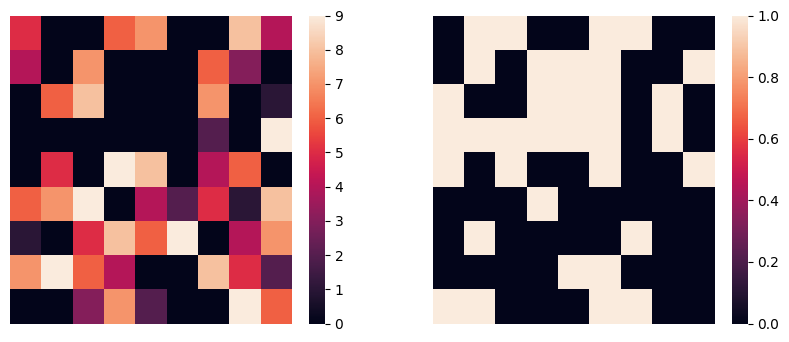

In [1654]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(grid, ax=ax1, xticklabels=[], yticklabels=[])
sns.heatmap(pmat, ax=ax2, xticklabels=[], yticklabels=[])
plt.show()

## Neighbours Definition

In [ ]:
def check_row_hard(i: int, j: int, d: int, v: int, frozen: np.ndarray) -> bool:
    return v not in frozen[i, :]


def check_col_hard(i: int, j: int, d: int, v: int, frozen: np.ndarray) -> bool:
    return v not in frozen[:, j]


def check_box_hard(i: int, j: int, d: int, v: int, frozen: np.ndarray) -> bool:
    return v not in frozen[(i // d) : (i // d) + d, (j // d) : (j // d) + d]


def check_row_soft(i: int, j: int, d: int, values: np.ndarray) -> bool:
    return dict(zip(*np.unique(values[i, :], return_counts=True)))[values[i, j]] == 1


def check_col_soft(i: int, j: int, d: int, values: np.ndarray) -> bool:
    return dict(zip(*np.unique(values[:, j], return_counts=True)))[values[i, j]] == 1


def check_box_soft(i: int, j: int, d: int, values: np.ndarray) -> bool:
    v: int = values[i, j]
    s: int = (i // d) * d
    k: int = (j // d) * d
    return dict(zip(*np.unique(values[s : s + d, k : k + d], return_counts=1)))[v] == 1

In [ ]:
def update_probability_matrix(probs: np.ndarray, guess: np.ndarray, frozen: np.ndarray):
    d: int = int(np.sqrt(probs.shape[0]))
    for (i, j), v in np.ndenumerate(guess):
        if probs[i, j] == 0:
            continue
        if not check_row_hard(i, j, d, guess[i, j], frozen):
            probs[i, j] = 1.0
        elif not check_col_hard(i, j, d, guess[i, j], frozen):
            probs[i, j] = 1.0
        elif not check_box_hard(i, j, d, guess[i, j], frozen):
            probs[i, j] = 1.0
        else:
            probs[i, j] = 0.000001
            probs[i, j] += 0.1 if not check_row_soft(i, j, d, guess) else 0
            probs[i, j] += 0.1 if not check_col_soft(i, j, d, guess) else 0
            probs[i, j] += 0.1 if not check_box_soft(i, j, d, guess) else 0

In [ ]:
def generate_guess(values: np.ndarray, probs: np.ndarray, shp: tuple) -> np.ndarray:
    n: int = values.size
    x = np.stack((values.reshape(-1), np.random.randint(1, dim, (n,))), axis=1)
    p = probs.reshape(-1)
    odds = np.stack((np.abs(p - 1), p), axis=1)
    guess = np.zeros((n,))
    for i, x in enumerate(x, 0):
        guess[i] = np.random.choice(x, p=odds[i])
    return guess.reshape(shp)

In [ ]:
def solve(values, frozen, shp):
    probs: np.ndarray = setup_probability_matrix(shp, frozen)
    state: np.ndarray = generate_guess(values, probs, shp)
    for step in range(1000):
        print("Step:", step)
        # temp: float = 1 - (step + 1) / 1000
        p0 = np.sum(probs == 1)
        iterstop = 0
        while np.sum(probs == 1) >= p0:
            state = generate_guess(state, probs, shp)
            update_probability_matrix(probs, state, frozen)
            iterstop += 1
            if iterstop > 100:
                break
        p0 = np.sum(probs == 1)
        print(p0)
    return state


# Let s = s0
# For k = 0 through kmax (exclusive):
# T ← temperature( 1 - (k+1)/kmax )
# Pick a random neighbour, snew ← neighbour(s)
# If P(E(s), E(snew), T) ≥ random(0, 1):
# s ← snew
# Output: the final state s

solve(values, frozen, shp)

#### Visualising Temperature Function

In [ ]:
from matplotlib.axes import Axes

In [ ]:
kmax: int = 100000
temp: list[float] = []
for k in range(kmax):
    temp.append(1 - (k + 1) / kmax)
plot: Axes = sns.lineplot(temp)
plot.set_xlabel("Step Number")
plot.set_ylabel("Temperature")
plt.show()

<Axes: >

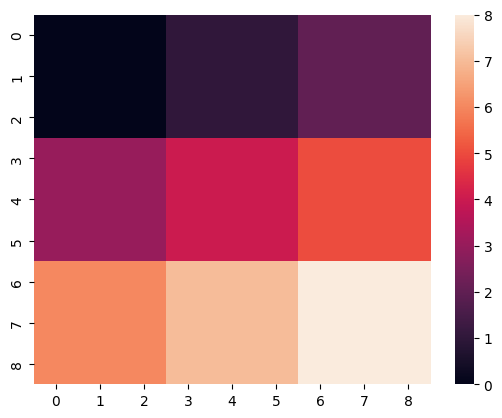

In [1682]:
shp = 9, 9
d: int = int(np.sqrt(shp[0]))
idxs = np.zeros(shp)
for i in range(shp[0]):
    for j in range(shp[1]):
        idxs[i, j] = i // d * d + j // d
        # print(i // d, j // d)  # + j // d)
sns.heatmap(idxs)